# Frank-Wolfe Algorithm

*Mar, 2017 by K.Wu*

In this report, network are presented as a CSV file:

- [**/data/Frank-Wolfe-algo-data.csv**](https://github.com/wklchris/Reports/blob/master/data/Frank-Wolfe-algo-data.csv): All links of the network.

First, here are the packages needed in this report. Install: 

- Python 3
- numpy package
- pandas package
- matplotlib package

to continue.

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

## Introduction

In this report, we have a network like below:

<img src="https://raw.githubusercontent.com/wklchris/Reports/master/pics/FrankWolfe-network.png" alt="Network Picture" style="width: 500px;"/>

The free flow travel time $t_a$ and capacities $c_a$ for each type of link are:

- Black links: $t_a = 10, c_a = 50$
- Red links: $t_a = 30, c_a = 200$
- Yellow links: $t_a = 15, c_a = 200$
- Cyan links: $t_a = 0, c_a = 2000$

We also have the O-D table of this network, shown as below:

In [2]:
ODarr = pd.DataFrame([[100, 200, 300, 50],
                      [100, 200, 200, 100],
                      [300, 50, 100, 100],
                      [200, 500, 50, 200]])

# Rename columns & rows
ODarr.columns = list(range(201, 205))
ODarr.index = list(range(101, 105))

ODarr

,201,202,203,204
101,100,200,300,50
102,100,200,200,100
103,300,50,100,100
104,200,500,50,200


## Network Representation



In [3]:
linkarr = pd.read_csv(r"{}/data/Frank-Wolfe-algo-data.csv".format(os.getcwd()))
linkarr.head()

,start,end,type
0,1,2,black
1,2,3,black
2,3,4,black
3,14,15,black
4,15,16,black


We can modify the link array according to the type:

In [4]:
linkarr["fftime"] = 0
linkarr["cap"] = 0

# Set the FreeFlowTraveltime and Capacity of each link
linkarr.loc[linkarr.type == "black", "fftime"] = 10
linkarr.loc[linkarr.type == "black", "cap"] = 50
linkarr.loc[linkarr.type == "yellow", "fftime"] = 15
linkarr.loc[linkarr.type == "yellow", "cap"] = 200
linkarr.loc[linkarr.type == "red", "fftime"] = 30
linkarr.loc[linkarr.type == "red", "cap"] = 200
linkarr.loc[linkarr.type == "cyan", "fftime"] = 0
linkarr.loc[linkarr.type == "cyan", "cap"] = 2000

linkarr.head(3)

,start,end,type,fftime,cap
0,1,2,black,10,50
1,2,3,black,10,50
2,3,4,black,10,50


## Application Scenarios

As for the costs, we use BPR function to compute the cost on each link. Cost on link $a$, called $t_a$, is a function of $x_a$:

$$ t_a(x_a) = t_a^0 \left[1 + \alpha\left(\frac{x_a}{c_a'}\right)^\beta\right] $$

where $\alpha = 0.15, \beta = 4, c_a' = 0.9c_a$. And we can define it as a function:

In [5]:
def bpr(xa, fft, ca, alpha=0.15, beta=4, ca_factor=0.9):
    """
    Compute the cost when the flow is 'xa' with BPR function.
    """
    return np.multiply(fft, 1 + alpha * (np.divide(xa, ca_factor * ca) ** beta))

As aforementioned, $\beta = 4$. So we need a function to search the numerical solution for quadratic equation:

In [6]:
def solvex4eq(q, theta=0.001, a=0, b=1):
    """
    Bi-section method to solve quartic equation.
    """
    y = lambda x: q[0] + q[1] * x + q[2] * x ** 2 + q[3] * x ** 3 + q[4] * x ** 4
    fa = y(a)
    fb = y(b)
    
    if fa * fb > 0:
        return list(map(y, np.linspace(a, b, 20)))
    elif (fa == 0):
        return a
    elif (fb == 0):
        return b
    
    while (b - a > theta):
        c = (b + a) / 2
        fc = y(c)
        if (fc == 0):
            return c
        elif (fc * fa < 0):
            b = c
            fb = fc
        elif (fc * fb < 0):
            a = c
            fa = fc
    
    return c

# Example: (x + 1)^3 * (x - 0.2) = 0
solvex4eq([-0.2, 0.4, 2.4, 2.8, 1])

0.2001953125

As for the shortest path finding, we use the function defined in the [Label-correcting-algo.ipynb](https://github.com/wklchris/Reports/blob/master/Label-correcting-algo.ipynb): (some modification included)

In [7]:
def label_correcting_algo(dt, ori_node, des_node, do_return=False):
    """
    Find the shortest path from Origin to Destination in a network.
    
    Args:
        dt: Network representation. At least 3 columns:
              "start": start nodes of links
              "end": end nodes of links
              "cost": constant costs of links
        ori_node: Origin node.
        des_node: Destination node.
        do_return: Boolean. 
            If True, Return a dataframe as described below.
            If False, Return the list of nodes on the shortest path.
        
    Returns:
        If do_return == True, return a dataframe of two columns:
            "Front-Node": The node visited before current node on the shortest path.
            "Distance": Total distance from origin to current node.
        If do_return == False, return a list.
    """
    # Convert all labels to string
    ori = str(ori_node)
    des = str(des_node)
    dt[["start", "end"]] = dt[["start", "end"]].astype(str) 
    
    # Initialization
    nodes = set(dt.loc[:,"start"].unique()) | set(dt.loc[:,"end"].unique())
    dist = {}.fromkeys(nodes, np.inf)
    dist[ori] = 0
    points = {}.fromkeys(nodes, ori)
    iter_set = {ori}
    
    # Main Algo
    while iter_set:
        i = iter_set.pop()  # Randomly pop out a node i
        A_i = dt[dt.start == i]
        for row in A_i.index: 
            j = A_i.loc[:, "end"][row]
            c_ij = A_i.loc[:, "cost"][row]
            if dist[j] > dist[i] + c_ij:
                dist[j] = dist[i] + c_ij
                points[j] = i
                iter_set = iter_set | set([j])  # Union
    
    # Print & Return the Answer
    x = pd.concat([pd.Series(points), pd.Series(dist)], axis=1)
    x.columns = ["Front-node", "Costs"]

    current_node = des
    front_node = ""
    sp = [des]
    while front_node != ori:
        front_node = str(x.loc[current_node, "Front-node"])
        # sp = "{} -> {}".format(front_node, sp)
        sp.insert(0, front_node)
        current_node = front_node
    
    if do_return:
        print(sp)
        return x
    else:
        return sp

First, we use free flow travel time to find the initial shortest path. So the cost under this situation equals free flow travel time:

In [8]:
bprlinkarr = linkarr.copy()
bprlinkarr["cost"] = bprlinkarr.fftime
del(bprlinkarr["type"])

bprlinkarr.head()

,start,end,fftime,cap,cost
0,1,2,10,50,10
1,2,3,10,50,10
2,3,4,10,50,10
3,14,15,10,50,10
4,15,16,10,50,10


Define a function to implement the algorithm:

1. Initialization
2. Do AON assignment for every O-D pair based on current link costs
3. Load those flow on the network, and re-compute costs on each link
4. Do the line search and find the numerical solution of "k"
5. Update the flow on each link by $x_a + k\times direction$
6. Check the err. If err > thre, go to step 2; otherwise, next.
7. Return a dataframe with assignments in each iteration.

For user equilibrium (UE), the object function in iteration $i$ is:

$$ z_1(k) = \sum_a \int_0^{x_a + k\times d_a} t_a(x)\,\mathrm{d} x $$

It should have a minimal between [0, 1]. Then:

$$\exists k^*, \quad\textrm{s.t. } \left.\frac{\\,\mathrm{d} z_1}{\,\mathrm{d} k}\right|_{k=k^*} = 0$$

Therefore, we have (omit iteration label $i$):

$$
\sum_a t_a^0 \left[1 + \alpha\left(\frac{x_a + k^*d_a}{c_a'}\right)^\beta\right]\cdot d_a = 0
$$

Simplify the coeffecients and put them into the function defined below. Similarly, we can get the coeffecients under system optimal (SO) scenario, which is also included in the function.

In [9]:
def bpr_coef(df, d, xa_idx_str, eq_type="ue", alpha=0.15):
    p4 = alpha * sum(np.multiply(df.fftime, np.divide(d ** 5, (0.9 * df.cap) ** 4)))
    p3 = alpha * 4 * sum(np.multiply(df.fftime, np.divide(np.multiply(df[xa_idx_str], d ** 4), (0.9 * df.cap) ** 4)))
    p2 = alpha * 6 * sum(np.multiply(df.fftime, np.divide(np.multiply(df[xa_idx_str] ** 2, d ** 3), (0.9 * df.cap) ** 4)))
    p1 = alpha * 4 * sum(np.multiply(df.fftime, np.divide(np.multiply(df[xa_idx_str] ** 3, d ** 2), (0.9 * df.cap) ** 4)))
    p0 = sum(alpha * np.multiply(df.fftime, np.divide(np.multiply(d, df[xa_idx_str] ** 4), (0.9 * df.cap) ** 4)) + np.multiply(df.fftime, d))
    
    if (eq_type != "ue"):
        p4 *= 5
        p3 *= 5
        p2 *= 5
        p1 *= 5
        p0 = 5 * p0 - 4 * sum(np.multiply(df.fftime, d))
    
    return [p0, p1, p2, p3, p4]

Also define a function for Q5 & Q6:

In [10]:
def davidson_solve(df, d, xa_idx_str, theta=0.005, a=1e-5, b=1, J=0.25, test=0):
    """
    Bi-section method to solve the equation in Davidson's link function scenario.
    """
    tmp = df[xa_idx_str]
    y = lambda k: sum(np.multiply(np.multiply(df.fftime, d), 1 + 0.25 * (np.divide(tmp + k * d, df.cap - (tmp + k * d)))))
    N = len(df)

    fa = y(a)
    fb = y(b)
    
    # Check margin points
    if (fa == 0):
        return a
    elif (fb == 0):
        return b
    elif (fa * fb > 0):
        return list(map(y, np.linspace(a, b, 20)))
    
    while (b - a > theta):
        c = (b + a) / 2
        fc = y(c)
        if (fc == 0):
            return c
        elif (fc * fb < 0):
            a = c
            fa = fc
        elif (fc * fa < 0):
            b = c
            fb = fc

    return c

Then we define the main function:

In [11]:
def frank_wolfe(dt, OD_arr, eq="ue", linkf="bpr", thre=1, max_iters=70, alpha=0.15):
    """
    The main function for solving these problems.
    
    Args:
        dt: Initial input dataframe. With columns:
            "start": start node of a link.
            "end": end node of the link.
            "fftime": free flow travel time through the link.
            "cost": current cost on this link. Under initial condition, it's identical with "fftime".
            "cap": capacity of the link.
        OD_arr: O-D pairs dataframe with demands. Indices names are O, columns names are D.
        eq: If it's "ue", than solve UE problem; otherwise, solve SO problem.
        linkf: If it's "bpr", than use BPR function as the link performance function; otherwise, use Davidson's.
        thre: The threshold of error to stop iterations.
        max_iters: The max number of iteratiions in case there's no convergence.
        alpha: The multiplier "alpha" in the BPR function. Default value is 0.15.
    """
    ori_lst = OD_arr.index
    des_lst = OD_arr.columns
    err = thre + 1
    iters = 0
    x = dt.copy()  # Deepcopy
    x.cost = x.fftime  # Double-check for s.p. algo
    
    while (err > thre):
        new_col = "xa{}".format(iters)
        x[new_col] = 0
        x["cost{}".format(iters)] = 0
        
        # AON assignment
        sp_arr = {}
        for i in range(len(ori_lst)):
            ori = ori_lst[i]
            for j in range(len(des_lst)):
                des = des_lst[j]
                demand = OD_arr.at[ori, des]
                splst = label_correcting_algo(x, ori, des)
                # Shortest path for each OD pair
                while len(splst) > 1:
                    current_node = splst.pop()
                    front_node = splst[-1]
                    x.loc[(x.start == front_node) & (x.end == current_node), new_col] += demand
        
        # Line search
        if (iters > 0):
            direction = x[new_col] - x[old_col]
            
            # Compute the coefficients of the equation of k. 
            # eq = "ue" / "so"
            if (linkf == "bpr"):
                coef_lst = bpr_coef(x, direction, old_col, eq_type=eq)
                
                # Numerical Solution
                k = solvex4eq(coef_lst)
                if (type(k) == type([])):
                    err = np.sqrt(sum((x[old_col] - x["xa{}".format(iters - 2)]) ** 2)) / sum(x["xa{}".format(iters - 2)])
                    print("Solving terminated for {}. Iteration: {}. Error {:.4f}".format(eq.upper(), iters - 1, err))
                    return x.iloc[:, :-2]
            else:  # Davidson's link function. J=0.25.
                k = davidson_solve(x, direction, old_col, test=iters)
                print(k)
                if (type(k) == type([])):
                    err = np.sqrt(sum((x[old_col] - x["xa{}".format(iters - 2)]) ** 2)) / sum(x["xa{}".format(iters - 2)])
                    print("Solving terminated for {}. Iteration: {}. Error {:.4f}".format(eq.upper(), iters - 1, err))
                    return x
            x[new_col] = x[old_col] + k * direction
            
            # Compute the error
            err = np.sqrt(sum((x[new_col] - x[old_col]) ** 2)) / sum(x[old_col])

        # Update the costs
        # xa-[iters] is computed based on cost-[iters] (so cost1 == fftime)
        x["cost{}".format(iters)] = x.cost
        x.cost = bpr(x[new_col], x.fftime, x.cap)
        
        # Non-convergence Break
        if (iters > max_iters):
            print("Force stop at Iteration {}. Final error: {:.4f}".format(max_iters, err))
            return x
        
        # Move forward
        old_col = "xa{}".format(iters)
        iters += 1
    
    # End of while loop
    print("Total iteration: {} for {}. Error: {:.4f}.".format(iters, eq.upper(), err))
    return x

### Q1

*Find the user equilibrium (UE) flow pattern, and compute the total travel time experienced by all users (this is not to be confused with the sum of the integral of travel times). Plot the convergence curves (total network link flow vs iteration number, total network travel time vs iteration number) and discuss your results.*

-----

Here's the solution for Q1:

In [12]:
q1 = frank_wolfe(bprlinkarr, ODarr, thre=0.001)
q1

Total iteration: 49 for UE. Error: 0.0009.


,start,end,fftime,cap,cost,xa0,cost0,xa1,cost1,xa2,...,xa44,cost44,xa45,cost45,xa46,cost46,xa47,cost47,xa48,cost48
0,1,2,10,50,1002.526438,550,10,276.611328,33482.793781,204.688787,...,228.583888,906.231775,223.177540,1008.673828,228.503093,917.492721,223.447829,1007.262604,228.231308,921.896953
1,2,3,10,50,793.642115,700,10,352.050781,87838.074989,240.315914,...,220.077781,807.164879,213.415270,868.115999,217.051152,768.827684,210.904196,821.875784,215.138998,733.739180
2,3,4,10,50,888.509320,550,10,276.611328,33482.793781,188.819647,...,224.168032,833.806025,218.895367,933.710588,224.400737,849.822457,219.461654,937.552122,221.373837,858.546793
3,14,15,10,50,765.374238,450,10,226.318359,15010.000000,154.488802,...,208.411409,811.770811,215.725126,700.124052,208.765966,802.216951,215.597789,704.832299,213.172040,800.348101
4,15,16,10,50,421.194050,600,10,301.757812,47417.407407,205.985069,...,180.821837,485.801794,187.457113,401.061185,179.585379,461.698767,185.827590,390.474108,183.105506,446.196306
5,16,9,10,50,1065.165401,600,10,301.757812,47417.407407,205.985069,...,229.344032,1141.731676,234.510375,1022.024391,228.861990,1116.342125,233.708672,1013.542766,231.750049,1101.290853
6,8,1,15,200,60.520602,0,15,596.484375,15.000000,597.600174,...,385.833384,59.736776,380.207569,62.499792,385.237915,59.789429,379.991919,62.207238,381.749850,59.687900
7,1,9,15,200,908.462047,100,15,969.873047,15.214335,1042.911386,...,807.249496,926.816581,807.030028,925.172327,806.734822,924.182935,806.544090,922.853372,803.518542,921.995120
8,9,10,15,200,42.080955,0,15,571.630859,15.000000,548.896456,...,336.593528,44.825532,341.540403,42.511581,335.596812,44.164924,340.252762,42.187158,335.268591,43.727586
9,10,9,15,200,15.000000,0,15,0.000000,15.000000,0.000000,...,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000


Draw a animation graph to show the result:

In [13]:
links = np.arange(len(q1)) + 1
iters = (q1.shape[1] - 5) // 2
iterlst = list(map(lambda x: "xa{}".format(x), np.arange(iters)))
y = list(np.array(q1[iterlst].T))

# Draw animation graphs
fig, ax = plt.subplots()
fig.set_tight_layout(True)

ax.plot(links, q1.iloc[:, -2], 'r-', linewidth=2)
plt.hold(True)
line, = ax.plot(links, links - 5, 'k-')
ax.plot([28, 28], [0, 2000], 'k--')
ax.text(30, 1500, "Dummy links")
ax.axis(ymin=0)
ax.set_xlabel("# of links")
ax.set_ylabel("Flow")
plt.hold(False)

def update(i):
    global q1, iters
    line.set_ydata(q1.loc[:, "xa{}".format(i)])
    ax.set_title("Iteration {} (Total {})".format(i, iters))
    return line, ax

anim = FuncAnimation(fig, update, np.arange(iters), interval=0.3*1000)

In [14]:
# Save the animation
anim.save(r'{}/pics/FrankWolfe-q1-linkflow.gif'.format(os.getcwd()), dpi=100, writer='imagemagick')

Here's the animation graph:

<img src="https://raw.githubusercontent.com/wklchris/Reports/master/pics/FrankWolfe-q1-linkflow.gif" alt="Network Picture" style="width: 700px;"/>

Of course, we can draw figures of total flow/travel time vs iteration:

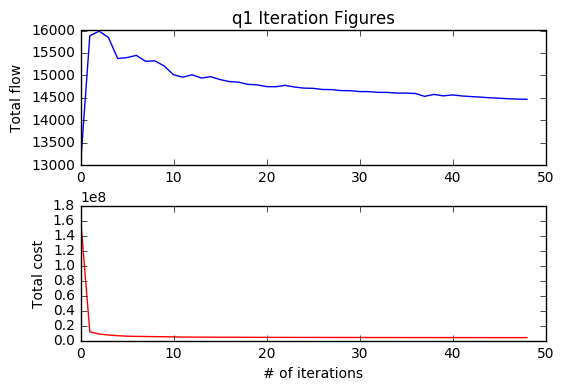

In [15]:
q1_iters = (q1.shape[1] - 5) // 2
q1_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(q1_iters)))
q1_costlst = q1[q1_iterlst].apply(bpr, fft=q1.fftime, ca=q1.cap)

q1_xa_total = q1[q1_iterlst].apply(sum)
q1_cost_total = np.multiply(q1[q1_iterlst], q1_costlst).apply(sum)

# Plotting
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q1_iters), q1_xa_total, "b-")
#plt.hold(True)
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("q1 Iteration Figures")

axarr[1].plot(np.arange(q1_iters), q1_cost_total, "r-")
axarr[1].set_ylabel("Total cost")
axarr[1].set_xlabel("# of iterations")

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q1.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

## Q2

Find the system optimal (SO) flow pattern, and compare the total travel time in the SO pattern with that of the UE pattern. Comment on your results. Also, plot the convergence curves (total network link flow vs iteration number, total network travel time vs iteration number) and discuss your results.

-----

Similarly:

In [16]:
q2 = frank_wolfe(bprlinkarr, ODarr, eq="so", thre=0.001)
q2

Total iteration: 37 for SO. Error: 0.0009.


,start,end,fftime,cap,cost,xa0,cost0,xa1,cost1,xa2,...,xa32,cost32,xa33,cost33,xa34,cost34,xa35,cost35,xa36,cost36
0,1,2,10,50,939.189904,550,10,275.537109,33482.793781,203.515005,...,219.779184,966.708401,223.971441,863.468372,228.771356,930.474534,221.613519,1011.954022,224.499728,892.320161
1,2,3,10,50,910.394772,700,10,350.683594,87838.074989,238.697720,...,218.645069,978.570339,224.756020,845.987819,227.621757,943.440272,218.507996,991.965640,222.739859,843.893400
2,3,4,10,50,816.321430,550,10,275.537109,33482.793781,187.548208,...,211.124682,823.577759,215.426810,736.770409,220.552156,797.843952,213.723408,875.538587,216.678964,773.219686
3,14,15,10,50,736.198661,450,10,225.439453,15010.000000,153.448534,...,207.190778,764.119221,210.273317,684.097763,215.594938,725.118253,208.964672,800.306303,211.083147,707.481487
4,15,16,10,50,479.158005,600,10,300.585938,47417.407407,204.598045,...,188.352465,543.405700,191.039397,470.390588,195.189263,497.228803,187.374068,540.963789,189.242851,460.898871
5,16,9,10,50,1050.239736,600,10,300.585938,47417.407407,204.598045,...,230.469103,1132.463265,232.621351,1042.029356,238.996124,1081.123376,229.426943,1203.451107,230.926120,1023.488620
6,8,1,15,200,65.793444,0,15,598.828125,15.000000,599.202347,...,395.293515,65.284634,392.814203,67.332473,385.470693,66.031840,394.060245,62.321441,392.354638,66.682438
7,1,9,15,200,973.953521,100,15,973.291016,15.214335,1045.687342,...,825.514331,961.676489,818.842762,1010.384711,806.699337,978.595041,822.446727,922.693650,817.854910,995.671611
8,9,10,15,200,46.717863,0,15,573.876953,15.000000,550.285387,...,355.983434,47.379044,351.464113,49.420062,345.695460,47.705173,351.873669,45.610273,348.781030,47.857883
9,10,9,15,200,15.000000,0,15,0.000000,15.000000,0.000000,...,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000,0.000000,15.000000


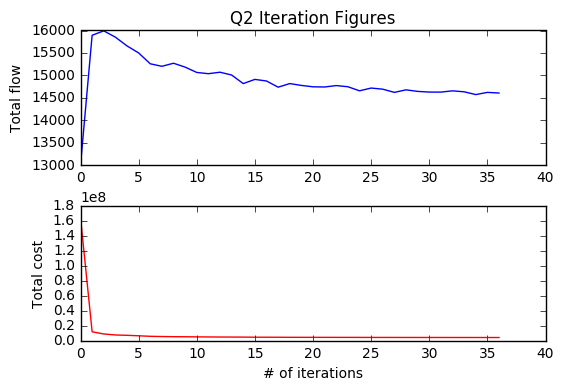

In [17]:
q2_iters = (q2.shape[1] - 5) // 2
q2_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(q2_iters)))
q2_costlst = q2[q2_iterlst].apply(bpr, fft=q2.fftime, ca=q2.cap)

q2_xa_total = q2[q2_iterlst].apply(sum)
q2_cost_total = np.multiply(q2[q2_iterlst], q2_costlst).apply(sum)

# Plotting
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q2_iters), q2_xa_total, "b-")
#plt.hold(True)
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("Q2 Iteration Figures")

axarr[1].plot(np.arange(q2_iters), q2_cost_total, "r-")
axarr[1].set_ylabel("Total cost")
axarr[1].set_xlabel("# of iterations")

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q2.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

## Q1 vs Q2

Compare UE and SO results:

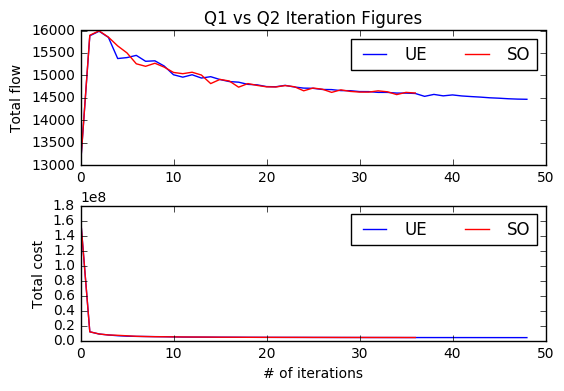

In [18]:
# Plotting
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q1_iters), q1_xa_total, "b-", label="UE")
axarr[0].hold(True)
axarr[0].plot(np.arange(q2_iters), q2_xa_total, "r-", label="SO")
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("Q1 vs Q2 Iteration Figures")
axarr[0].legend(loc="upper right", ncol=2)

axarr[1].plot(np.arange(q1_iters), q1_cost_total, "b-", label="UE")
axarr[1].hold(True)
axarr[1].plot(np.arange(q2_iters), q2_cost_total, "r-", label="SO")
axarr[1].set_ylabel("Total cost")
axarr[1].set_xlabel("# of iterations")
axarr[1].legend(loc="upper right", ncol=2)

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q1-vs-q2.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

Except Q1 (UE) takes more iterations than Q2 (SO) to reach the error threshold, there's nearly no difference between total flow and total cost of these two equilibrium.

If we view the last iteration of q1 and q2 matrices shown above, we can also find there's few differences between link flow of these two.

## Q3

Find a number of bottleneck links (tell me your criteria of judging bottleneck links) in your network based on results from part 1, expand their capacities by a suitable amount, say 50%, and redo parts 1 & 2 (no need for plot the convergence curves). Comment on your results.

-----

Inspired by the form of BPR model, I decide to use $\varphi = \frac{x_a}{c_a}$ as the criterion of bottleneck. In this report, I set the threshold of $\varphi = 2$, which means links with flow more than twice of their capacity have bottleneck.

In [19]:
q3_ue = bprlinkarr.copy()
q3_so = bprlinkarr.copy()
q3_ue["phi"] = np.divide(q1.iloc[:, -2], q3_ue.cap)
q3_so["phi"] = np.divide(q2.iloc[:, -2], q3_ue.cap)

# Expand the capacities of links with bottleneck
q3_ue.loc[q3_ue.phi > 2, "cap"] *= 1.5
q3_so.loc[q3_so.phi > 2, "cap"] *= 1.5

Then redo Q1:

In [20]:
q1_redo = frank_wolfe(q3_ue, ODarr, thre=0.001)
q1_redo.head()

Total iteration: 52 for UE. Error: 0.0009.


,start,end,fftime,cap,cost,phi,xa0,cost0,xa1,cost1,...,xa47,cost47,xa48,cost48,xa49,cost49,xa50,cost50,xa51,cost51
0,1,2,10,75.0,255.105534,4.564626,550,10,298.095703,6621.909883,...,241.883665,270.863012,244.945553,257.344541,241.709153,270.108418,244.564478,256.631504,241.334403,268.493530
1,2,3,10,75.0,147.229612,4.302780,700,10,379.394531,17358.755553,...,210.927654,162.929830,213.450211,153.024442,209.906604,159.990075,212.282114,150.275097,208.757899,156.733670
2,3,4,10,75.0,248.946867,4.427477,550,10,298.095703,6621.909883,...,240.210846,263.696886,243.320109,250.572854,240.110693,263.272583,243.008165,250.171890,239.803928,261.976265
3,14,15,10,75.0,186.325697,4.263441,450,10,243.896484,2972.962963,...,222.278483,195.801124,225.895596,186.386712,222.975455,198.151301,218.414578,188.609436,222.259258,174.438179
4,15,16,10,75.0,103.038678,3.662110,600,10,325.195312,9374.426155,...,191.045296,112.920885,194.130928,106.254616,190.908051,112.625453,185.874342,105.978320,189.429163,96.248976


Similarly redo Q2:

In [21]:
q2_redo = frank_wolfe(q3_so, ODarr, eq="so", thre=0.001)
q2_redo.head()

Total iteration: 26 for SO. Error: 0.0005.


,start,end,fftime,cap,cost,phi,xa0,cost0,xa1,cost1,...,xa21,cost21,xa22,cost22,xa23,cost23,xa24,cost24,xa25,cost25
0,1,2,10,75.0,257.862481,4.489995,550,10,295.947266,6621.909883,...,244.583612,297.083558,232.612159,268.574436,237.881293,221.546488,240.837548,241.375480,242.010192,253.093283
1,2,3,10,75.0,213.340166,4.454797,700,10,376.660156,17358.755553,...,234.086472,257.335605,219.684667,226.960879,227.658652,178.296528,229.566090,204.094313,230.322705,210.681399
2,3,4,10,75.0,234.876790,4.333579,550,10,295.947266,6621.909883,...,238.039482,267.381981,226.470647,241.991543,231.841739,200.074496,234.957240,218.757782,236.193051,230.207192
3,14,15,10,75.0,168.449165,4.221663,450,10,242.138672,2972.962963,...,214.635164,142.147219,204.506243,163.348547,208.581823,136.387012,214.947341,146.767214,216.398102,164.242649
4,15,16,10,75.0,134.265188,3.784857,600,10,322.851562,9374.426155,...,206.534083,111.155045,193.827396,141.474973,197.250184,111.985121,202.596126,119.381993,203.642457,131.730867


In [22]:
# Compute the flow of Q1_redo and Q2_redo
q1_redo_iters = (q1_redo.shape[1] - 5) // 2
q1_redo_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(q1_redo_iters)))
q1_redo_xa_total = q1_redo[q1_redo_iterlst].apply(sum)
q1_redo_costlst = q1_redo[q1_redo_iterlst].apply(bpr, fft=q1_redo.fftime, ca=q1_redo.cap)
q1_redo_cost_total = np.multiply(q1_redo[q1_redo_iterlst], q1_redo_costlst).apply(sum)

q2_redo_iters = (q2_redo.shape[1] - 5) // 2
q2_redo_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(q2_redo_iters)))
q2_redo_xa_total = q2_redo[q2_redo_iterlst].apply(sum)
q2_redo_costlst = q2_redo[q2_redo_iterlst].apply(bpr, fft=q2_redo.fftime, ca=q2_redo.cap)
q2_redo_cost_total = np.multiply(q2_redo[q2_redo_iterlst], q2_redo_costlst).apply(sum)

Comparation:

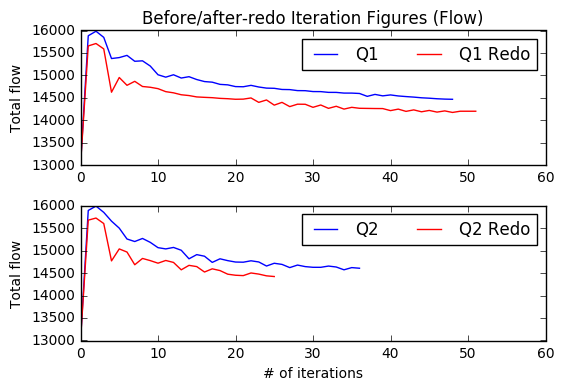

In [23]:
# Plotting: compare flow results before and after redo
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q1_iters), q1_xa_total, "b-", label="Q1")
axarr[0].hold(True)
axarr[0].plot(np.arange(q1_redo_iters), q1_redo_xa_total, "r-", label="Q1 Redo")
axarr[0].legend(loc="upper right", ncol=2)
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("Before/after-redo Iteration Figures (Flow)")

axarr[1].plot(np.arange(q2_iters), q2_xa_total, "b-", label="Q2")
axarr[1].hold(True)
axarr[1].plot(np.arange(q2_redo_iters), q2_redo_xa_total, "r-", label="Q2 Redo")
axarr[1].legend(loc="upper right", ncol=2)
axarr[1].set_ylabel("Total flow")
axarr[1].set_xlabel("# of iterations")

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q1-vs-q1redo-flow.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

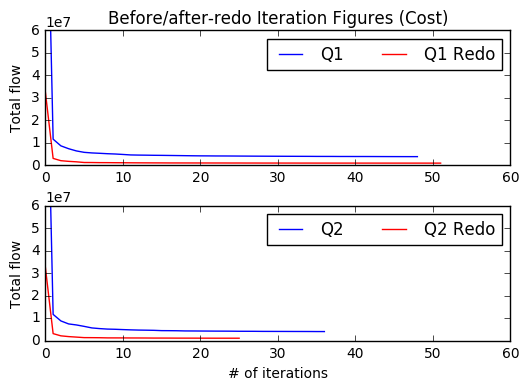

In [24]:
# Plotting: compare cost results before and after redo
plt.close("all")
fig, axarr = plt.subplots(2, sharex=True, sharey=False)
axarr[0].plot(np.arange(q1_iters), q1_cost_total, "b-", label="Q1")
axarr[0].hold(True)
axarr[0].plot(np.arange(q1_redo_iters), q1_redo_cost_total, "r-", label="Q1 Redo")
axarr[0].legend(loc="upper right", ncol=2)
axarr[0].set_ylabel("Total flow")
axarr[0].set_title("Before/after-redo Iteration Figures (Cost)")
axarr[0].axis(ymax=6e7)

axarr[1].plot(np.arange(q2_iters), q2_cost_total, "b-", label="Q2")
axarr[1].hold(True)
axarr[1].plot(np.arange(q2_redo_iters), q2_redo_cost_total, "r-", label="Q2 Redo")
axarr[1].legend(loc="upper right", ncol=2)
axarr[1].set_ylabel("Total flow")
axarr[1].set_xlabel("# of iterations")
axarr[1].axis(ymax=6e7)

# Show
fig.subplots_adjust(hspace=0.3)
fig.savefig(r'{}/pics/FrankWolfe-q1-vs-q1redo-cost.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

From above, we can see that flow and cost after redoing. To quantify it:

In [25]:
q3 = pd.DataFrame({"Q1": [q1_xa_total[-1], q1_cost_total[-1]], 
                   "Q1redo": [q1_redo_xa_total[-1], q1_redo_cost_total[-1]],
                   "Q2": [q2_xa_total[-1], q2_cost_total[-1]], 
                   "Q2redo": [q2_redo_xa_total[-1], q2_redo_cost_total[-1]]}, 
                  index=["Flow", "Cost"])
q3 = q3.applymap(np.rint)
q3["Q1reduction"] = np.divide(np.subtract(q3.Q1, q3.Q1redo), q3.Q1).apply(lambda x: "%.3f" % x)
q3["Q2reduction"] = np.divide(np.subtract(q3.Q2, q3.Q2redo), q3.Q2).apply(lambda x: "%.3f" % x)
q3

,Q1,Q1redo,Q2,Q2redo,Q1reduction,Q2reduction
Flow,14469.0,14203.0,14608.0,14424.0,0.018,0.013
Cost,3849142.0,958186.0,3981011.0,1019771.0,0.751,0.744


After expansion the capacity of bottlenecks, **the total flow does not reduce much, but the total cost has reduced by 75%.**

## Q4 

Multiply the O-D demand for each O-D pair in the table by 0.25, 0.5, 0.75, 1.25, 1.5, 2.0, 3.0, 5.0, and re-do parts 1 and 2 (no need to plot the convergence curves in this problem), and plot the total travel times in UE and SO against the multipliers in the same graph (i.e., the vertical axis would be total travel times under UE and SO, respectively, and the horizontal axis would be 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0), and discuss your results.

-----

In [26]:
multiplier = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 3, 5]

Compute UE and SO total cost (travel time):

In [27]:
q4_ue_cost = []
for k in multiplier:
    tmp = frank_wolfe(bprlinkarr, k * ODarr, thre=0.001)
    tmp_iters = (tmp.shape[1] - 5) // 2
    tmp_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(tmp_iters)))
    tmp_costlst = tmp[tmp_iterlst].apply(bpr, fft=tmp.fftime, ca=tmp.cap)
    tmp_cost_total = np.multiply(tmp[tmp_iterlst], tmp_costlst).apply(sum)
    q4_ue_cost.append(tmp_cost_total[-1])

Solving terminated for UE. Iteration: 1. Error 0.0732
Total iteration: 47 for UE. Error: 0.0010.
Total iteration: 44 for UE. Error: 0.0007.
Total iteration: 49 for UE. Error: 0.0009.
Total iteration: 42 for UE. Error: 0.0009.
Total iteration: 48 for UE. Error: 0.0009.
Total iteration: 51 for UE. Error: 0.0008.
Total iteration: 52 for UE. Error: 0.0009.
Total iteration: 61 for UE. Error: 0.0007.


In [28]:
q4_so_cost = []
for k in multiplier:
    tmp = frank_wolfe(bprlinkarr, k * ODarr, thre=0.001, eq="so")
    tmp_iters = (tmp.shape[1] - 5) // 2
    tmp_iterlst = list(map(lambda x: "xa{}".format(x), np.arange(tmp_iters)))
    tmp_costlst = tmp[tmp_iterlst].apply(bpr, fft=tmp.fftime, ca=tmp.cap)
    tmp_cost_total = np.multiply(tmp[tmp_iterlst], tmp_costlst).apply(sum)
    q4_so_cost.append(tmp_cost_total[-1])

Solving terminated for SO. Iteration: 1. Error 0.1144
Total iteration: 13 for SO. Error: 0.0001.
Total iteration: 34 for SO. Error: 0.0002.
Total iteration: 37 for SO. Error: 0.0009.
Total iteration: 48 for SO. Error: 0.0009.
Total iteration: 44 for SO. Error: 0.0009.
Total iteration: 59 for SO. Error: 0.0007.
Total iteration: 53 for SO. Error: 0.0009.
Total iteration: 61 for SO. Error: 0.0007.


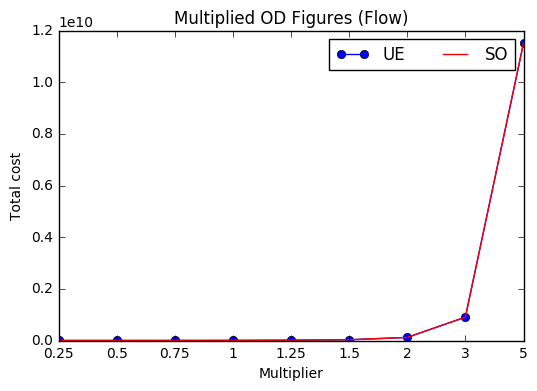

In [29]:
# Plotting: compare UE/SO total cost under different multipliers
plt.close("all")
fig, axarr = plt.subplots()
axarr.plot(np.arange(len(multiplier)), q4_ue_cost, "bo-", label="UE")
axarr.hold(True)
axarr.plot(np.arange(len(multiplier)), q4_so_cost, "r-", label="SO")
axarr.legend(loc="upper right", ncol=2)
axarr.set_xlabel("Multiplier")
axarr.set_ylabel("Total cost")
axarr.set_title("Multiplied OD Figures (Flow)")
axarr.set_xticklabels(map(str, multiplier))

# Show
fig.savefig(r'{}/pics/FrankWolfe-q4.png'.format(os.getcwd()), transparent=True, format="png")
plt.show()

Total costs under UE & SO are almost overlapped as above figure. **As multiplier increases linearly, the total cost increase exponentially.**

## Q5

Experiment with the Davidson's link performance function for the UE problem under the base demand:

$$ t_a = t_a^0\left[1 + J\frac{x_a}{c_a - x_a}\right], J = 0.25 $$

Discuss how convergence of Frank-Wolfe is affected.

-----

In UE scenario, similarly we set $\frac{\mathrm{d}\,z}{\mathrm{d}\,k} = 0$, then we have:

$$ \sum_a{t_a^0 d_a \left[1 + J\left(\frac{x_a + kd_a}{c_a - (x_a + kd_a)}\right)\right]} = 0$$

and that's how we compute $k$ with Davidson's link performance function.

In [30]:
# Because q5 CANNOT be solved by the algorithm above, I comment the line below
# q5 = frank_wolfe(bprlinkarr, ODarr, thre=0.001, linkf="davidson")

![Not Unimodal](https://raw.githubusercontent.com/wklchris/Reports/master/pics/FrankWolfe-q5-not-unimodal.png)

## Q6

Apply the incremental assignment algorithm to the network with Davidson’s link performance function, discuss your results.

-----

For the Q5 scenario seems not UNIMODAL, I didn't find a way to solve Q6.